# Custom Tutorial 3: Parameter inference

In this tutorial, we demonstrate how to fit your custom model to data. The process is nearly identical to that of the precoded sub-module, so we will principally focus on what's different between the precoded and custom versions here. Refer to Default Tutorial 3 for use details.

The specific model we will use for this example is the urgency gating model with time depenedent drift discussed in PyBEAM's publication. In this model, the drift rate flips from positive to negative at time t_flip. The model files for this example are on PyBEAM's github under the folder UGM_flip.

As before, import PyBEAM's custom sub-module. We additionally import matplotlib for plotting and os to check that our directory is input correctly.


In [9]:
# import PyBEAM's custom module
import pybeam.custom as pbc

# also import pyplot to modify figure axes
import matplotlib.pyplot as plt

# import os to check if you have input your model directory correctly
import os


In [10]:
# the directory containing your model goes here
model_dir = ''

# for windows computer, r before the directory is necessary
# model_dir = r''

# check if directory is input properly
os.path.isdir(model_dir)


True

In [11]:
# dictionary containing model parameters
phi = {'phi[0]' : 0.25, # tnd: non-decision time
       'phi[1]' : 0.5,  # w: relative start point
       'phi[2]' : 1.0,  # mu: drift rate
       'phi[3]' : 3.0,  # l: leakage rate
       'phi[4]' : 2.0,  # k: urgency ratio
       'phi[5]' : 0.5,  # t0: time for first drift rate flip
       'phi[6]' : 1.0,  # sigma: model scale
       'phi[7]' : 1.0}  # b: threshold location
    
# run function to test if model functions are input properly
pbc.functions_test(model_dir = model_dir, # string containing directory name where your model files are
                         phi = phi,       # dictionary of model parameters
                           x = 0.0,       # accumulator state
                           t = 1.0)       # time


[['non_decision_time', 0.25],
 ['relative_start', 0.5],
 ['drift', -3.0],
 ['diffusion', 3.0],
 ['upper_decision_threshold', 1.0],
 ['lower_decision_threshold', -1.0],
 ['contamination_strength', 0.0],
 ['contamination_probability', 0.0],
 ['modify_dt', 1.0]]

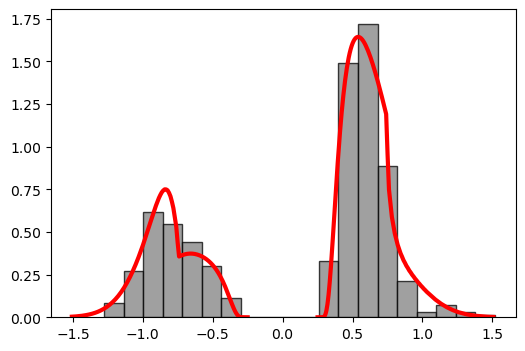

In [12]:
# set parameters for data set 0
phi0 = {'phi[0]' : 0.25,  # tnd: non-decision time
        'phi[1]' : 0.5,   # w: relative start point
        'phi[2]' : 1.0,   # mu: drift rate
        'phi[3]' : 3.0,   # l: leakage rate
        'phi[4]' : 2.0,   # k: urgency ratio
        'phi[5]' : 0.5,  # t1: time for second drift rate flip
        'phi[6]' : 1.0,   # sigma: model scale
        'phi[7]' : 1.0}   # a: threshold location

# simulate data for parameter set 0
rt0 = pbc.simulate(model_dir = model_dir,
                      N_sims = 500,
                         phi = phi0)

# plot data set 0
pbc.plot_rt(model_dir = model_dir,
                  phi = phi0,
                   rt = rt0,
               rt_max = 1.5);


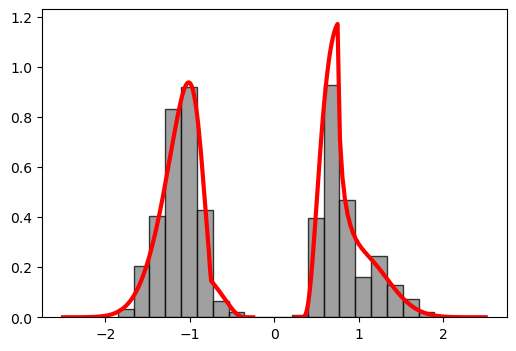

In [13]:
# set parameters for data set 1
phi1 = {'phi[0]' : 0.25,  # tnd: non-decision time
        'phi[1]' : 0.5,   # w: relative start point
        'phi[2]' : 1.0,   # mu: drift rate
        'phi[3]' : 3.0,   # l: leakage rate
        'phi[4]' : 2.0,   # k: urgency ratio
        'phi[5]' : 0.5,  # t1: time for second drift rate flip
        'phi[6]' : 1.0,   # sigma: model scale
        'phi[7]' : 1.5}   # a: threshold location

# simulate data for parameter set 1
rt1 = pbc.simulate(model_dir = model_dir,
                      N_sims = 500,
                         phi = phi1)

# plot data set 1
pbc.plot_rt(model_dir = model_dir,
                  phi = phi1,
                   rt = rt1,
               rt_max = 2.5);


In [14]:
# define bank of priors
p = {'pphi[0]' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)',   # non-decision time prior
     'pphi[1]' : 'Uniform("w", lower = 0.3, upper = 0.7)',       # relative start point prior
     'pphi[2]' : 'Uniform("mu", lower = -5.0, upper = 5.0)',     # drift rate prior
     'pphi[3]' : 'Uniform("l", lower = 0.0, upper = 10.0)',      # leakage rate prior
     'pphi[4]' : 'Uniform("k", lower = 0.0, upper = 10.0)',      # urgency rate prior
     'pphi[5]' : 'Uniform("t_flip", lower = 0.01, upper = 1.0)', # first drift flip time
     'pphi[6]' : 1.0,                                            # scaling parameter
     'pphi[7]0' : 'Uniform("a0", lower = 0.25, upper = 3.0)',    # decision threshold prior 0
     'pphi[7]1' : 'Uniform("a1", lower = 0.25, upper = 3.0)'}    # decision threshold prior 1

# define condition 0 dictionary
c0 = {'rt' : rt0,
  'phi[0]' : 'pphi[0]', 
  'phi[1]' : 'pphi[1]',  
  'phi[2]' : 'pphi[2]', 
  'phi[3]' : 'pphi[3]',  
  'phi[4]' : 'pphi[4]',  
  'phi[5]' : 'pphi[5]',
  'phi[6]' : 'pphi[6]', 
  'phi[7]' : 'pphi[7]0'}

# define condition 1 dictionary
c1 = {'rt' : rt1,
  'phi[0]' : 'pphi[0]', 
  'phi[1]' : 'pphi[1]',  
  'phi[2]' : 'pphi[2]', 
  'phi[3]' : 'pphi[3]',  
  'phi[4]' : 'pphi[4]',  
  'phi[5]' : 'pphi[5]',
  'phi[6]' : 'pphi[6]', 
  'phi[7]' : 'pphi[7]1'}
 
cond = {0 : c0, 1 : c1}

trace = pbc.inference(model_dir = model_dir, # specify model directory
                         priors = p,         # dictionary of priors
                     conditions = cond,      # conditions dictionary
                        samples = 50000,     # MCMC samples
                         chains = 3,         # MCMC chains 
                          cores = 3,         # CPU cores to run MCMC chains on
                      file_name = 'custom')  # output file name


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [t_nd, w, mu, l, k, t_flip, a0, a1]


Sampling 3 chains for 0 tune and 50_000 draw iterations (0 + 150_000 draws total) took 131 seconds.


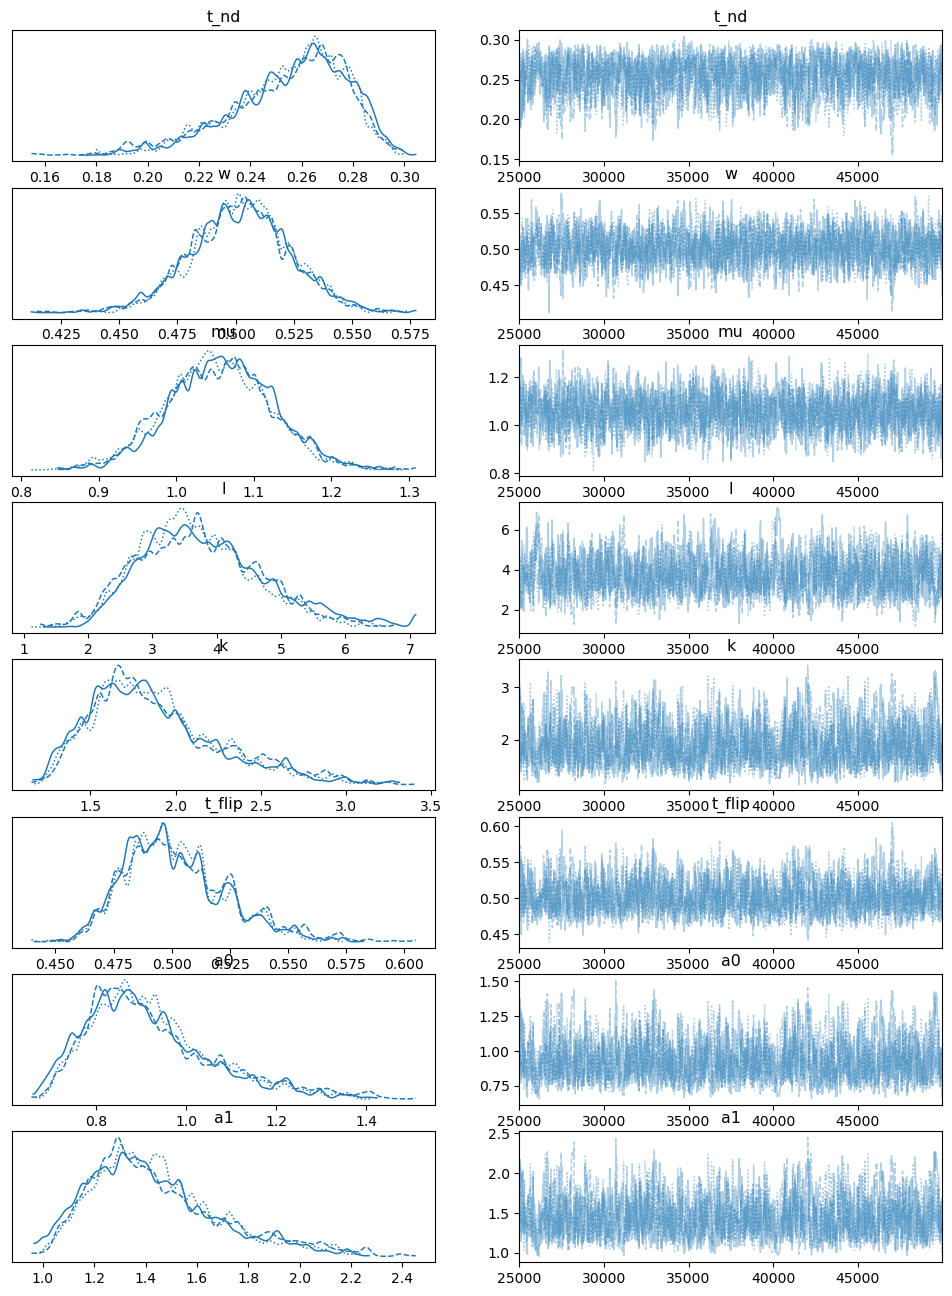

In [15]:
# plot posteriors
pbc.plot_idata(file_name = 'custom', burnin = 25000);


In [16]:
# summary of posteriors
pbc.summary(file_name = 'custom', burnin = 25000)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_nd,0.255,0.022,0.213,0.292,0.001,0.001,840.0,1003.0,1.00
w,0.502,0.021,0.464,0.543,0.001,0.000,1317.0,1928.0,1.00
mu,1.056,0.067,0.929,1.180,0.002,0.001,1426.0,2025.0,1.01
l,3.745,0.934,2.122,5.515,0.035,0.026,702.0,750.0,1.00
k,1.885,0.382,1.296,2.653,0.014,0.010,786.0,879.0,1.00
t_flip,0.502,0.022,0.465,0.543,0.001,0.001,958.0,1079.0,1.00
a0,0.922,0.141,0.701,1.206,0.005,0.004,721.0,788.0,1.00
a1,1.438,0.253,1.041,1.956,0.010,0.007,700.0,816.0,1.00
